In [49]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [50]:
torch.manual_seed(89)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [51]:
# This is a basic CNN model with two convolutional layers, followed by two fully connected layers.
# It takes a 1-channel input (e.g., grayscale image) and gradually increases the feature depth.
# After extracting features using conv layers and max pooling, it flattens the output and passes it 
# through a couple of dense layers to predict the class scores for 10 classes.

# The forward pass applies ReLU activations and max pooling after each conv layer,
# then flattens the data and passes it through the dense layers.

class FirstCNNModel(nn.Module):
    def __init__(self):
        super(FirstCNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Convolution + ReLU + Pooling for the first layer
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolution + ReLU + Pooling for the second layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully Connected Layer + ReLU
        x = F.relu(self.fc1(x))
        
        # Output Layer with log_softmax activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [52]:
# This is a deeper CNN model compared to the first one. It has an additional convolutional layer,
# which allows it to capture more complex patterns in the data. 
# The final dense layer is also larger, enabling the model to learn more abstract features
# before making predictions. Great for slightly more complex datasets.

# The forward pass is similar to Model1 but with an extra conv layer.
# More layers mean a deeper understanding of the input, though at the cost of more computations.

class SecondCNNModel(nn.Module):
    def __init__(self):
        super(SecondCNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=128 * 3 * 3, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        # Convolution + ReLU + Pooling for the first layer
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolution + ReLU + Pooling for the second layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # Convolution + ReLU + Pooling for the third layer
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        
        # Fully Connected Layer + ReLU
        x = F.relu(self.fc1(x))
        
        # Output Layer with log_softmax activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [53]:
# This model is even deeper, with four convolutional layers and a dynamically calculated 
# first fully connected layer. It's designed for very complex datasets where we need to capture 
# intricate patterns. The dynamic calculation ensures flexibility in handling different input sizes.
# It might be a bit overkill for simple tasks but can work wonders on challenging ones.

# The forward pass goes through all four conv layers with ReLU activations and max pooling.
# The first fully connected layer is calculated on-the-fly, adapting to the input dimensions.


class ThirdCNNModel(nn.Module):
    def __init__(self):
        super(ThirdCNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers (fc1 will be dynamically calculated)
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        # Convolution + ReLU + Pooling for the first layer
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolution + ReLU + Pooling for the second layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # Convolution + ReLU + Pooling for the third layer
        x = self.pool(F.relu(self.conv3(x)))
        
        # Convolution + ReLU + Pooling for the fourth layer
        x = self.pool(F.relu(self.conv4(x)))
        
        # Dynamically calculate the size of fc1 during the first forward pass
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 512).to(x.device)
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layer + ReLU
        x = F.relu(self.fc1(x))
        
        # Output Layer with log_softmax activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [54]:
# Populating the Dataset

batch_size_val = 128

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_mnist = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size_val, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batch_size_val, shuffle=True)

In [55]:
"""
    This function handles the training process for a given model over multiple epochs.
    It uses cross-entropy loss to measure the performance and backpropagation to update the model parameters.
    During each epoch, it iterates over the training data and testing data in batches, computes the loss, and updates the model weights.
    It also tracks and prints the train and test loss and accuracy for each epoch to monitor the model's progress.
"""


def train_the_model(model, optimizer, num_epochs, train_loader, test_loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    training_losses = []
    training_accuracies = []
    testing_losses = []
    testing_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_losses.append(running_loss / len(train_loader))
        training_accuracies.append(100 * correct / total)

        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        testing_losses.append(test_loss / len(test_loader))
        testing_accuracies.append(100 * correct / total)

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {training_losses[-1]:.4f}, Train Accuracy: {training_accuracies[-1]:.2f}%, '
                  f'Test Loss: {testing_losses[-1]:.4f}, Test Accuracy: {testing_accuracies[-1]:.2f}%')
            
    return training_losses, training_accuracies, testing_losses, testing_accuracies


In [56]:
num_epochs = 50

# Model 1
cnn_model1 = FirstCNNModel().to(device)
optimizer_cnn1 = optim.Adam(cnn_model1.parameters(), lr=0.001)

# Model 2
cnn_model2 = SecondCNNModel().to(device)
optimizer_cnn2 = optim.Adam(cnn_model2.parameters(), lr=0.001)

# Model 3
cnn_model3 = ThirdCNNModel().to(device)
optimizer_cnn3 = optim.Adam(cnn_model3.parameters(), lr=0.001)

# Train all three models with the additional test_loader argument
losses_cnn1, acc_cnn1, test_losses_cnn1, test_acc_cnn1 = train_the_model(cnn_model1, optimizer_cnn1, num_epochs, train_loader_mnist, test_loader_mnist)
losses_cnn2, acc_cnn2, test_losses_cnn2, test_acc_cnn2 = train_the_model(cnn_model2, optimizer_cnn2, num_epochs, train_loader_mnist, test_loader_mnist)
losses_cnn3, acc_cnn3, test_losses_cnn3, test_acc_cnn3 = train_the_model(cnn_model3, optimizer_cnn3, num_epochs, train_loader_mnist, test_loader_mnist)


 20%|██        | 10/50 [00:41<02:44,  4.11s/it]

Epoch 10/50, Train Loss: 0.0072, Train Accuracy: 99.75%, Test Loss: 0.0402, Test Accuracy: 99.04%


 40%|████      | 20/50 [01:22<02:03,  4.10s/it]

Epoch 20/50, Train Loss: 0.0010, Train Accuracy: 99.97%, Test Loss: 0.0433, Test Accuracy: 99.07%


 60%|██████    | 30/50 [02:02<01:21,  4.08s/it]

Epoch 30/50, Train Loss: 0.0035, Train Accuracy: 99.89%, Test Loss: 0.0479, Test Accuracy: 99.16%


 80%|████████  | 40/50 [02:43<00:40,  4.09s/it]

Epoch 40/50, Train Loss: 0.0014, Train Accuracy: 99.95%, Test Loss: 0.0498, Test Accuracy: 99.17%


100%|██████████| 50/50 [03:24<00:00,  4.10s/it]


Epoch 50/50, Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.0546, Test Accuracy: 99.15%


 20%|██        | 10/50 [00:41<02:45,  4.15s/it]

Epoch 10/50, Train Loss: 0.0097, Train Accuracy: 99.69%, Test Loss: 0.0339, Test Accuracy: 99.04%


 40%|████      | 20/50 [01:23<02:04,  4.15s/it]

Epoch 20/50, Train Loss: 0.0042, Train Accuracy: 99.87%, Test Loss: 0.0299, Test Accuracy: 99.32%


 60%|██████    | 30/50 [02:04<01:22,  4.15s/it]

Epoch 30/50, Train Loss: 0.0045, Train Accuracy: 99.87%, Test Loss: 0.0366, Test Accuracy: 99.10%


 80%|████████  | 40/50 [02:46<00:41,  4.15s/it]

Epoch 40/50, Train Loss: 0.0029, Train Accuracy: 99.93%, Test Loss: 0.0438, Test Accuracy: 99.32%


100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


Epoch 50/50, Train Loss: 0.0000, Train Accuracy: 100.00%, Test Loss: 0.0390, Test Accuracy: 99.46%


 20%|██        | 10/50 [00:42<02:49,  4.23s/it]

Epoch 10/50, Train Loss: 0.0097, Train Accuracy: 99.67%, Test Loss: 0.0348, Test Accuracy: 99.12%


 40%|████      | 20/50 [01:24<02:07,  4.24s/it]

Epoch 20/50, Train Loss: 0.0053, Train Accuracy: 99.83%, Test Loss: 0.0391, Test Accuracy: 99.17%


 60%|██████    | 30/50 [02:07<01:24,  4.24s/it]

Epoch 30/50, Train Loss: 0.0035, Train Accuracy: 99.88%, Test Loss: 0.0638, Test Accuracy: 99.07%


 80%|████████  | 40/50 [02:49<00:42,  4.24s/it]

Epoch 40/50, Train Loss: 0.0036, Train Accuracy: 99.90%, Test Loss: 0.0473, Test Accuracy: 99.18%


100%|██████████| 50/50 [03:31<00:00,  4.24s/it]

Epoch 50/50, Train Loss: 0.0025, Train Accuracy: 99.92%, Test Loss: 0.0610, Test Accuracy: 99.23%


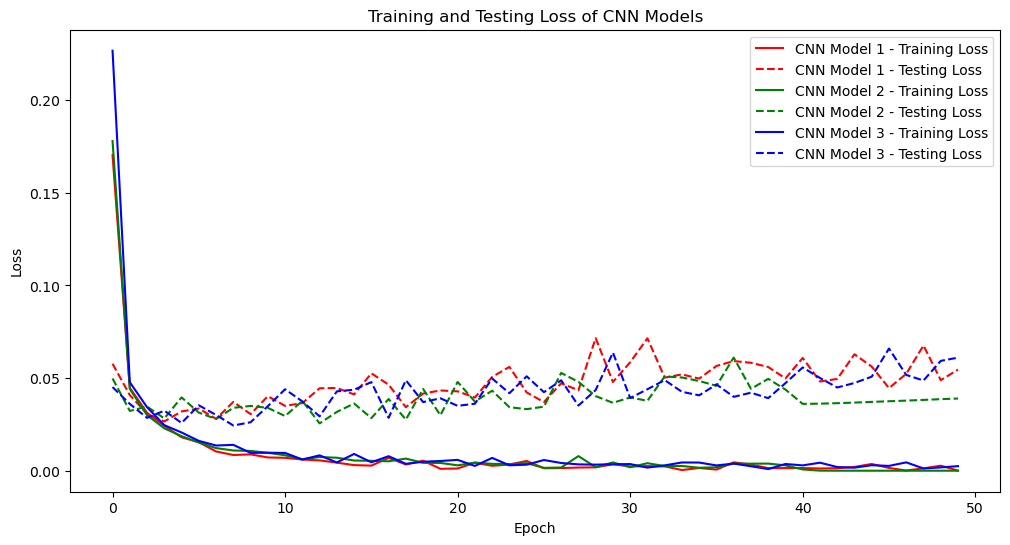

In [57]:
plt.figure(figsize=(12, 6))

# Plot Training Loss for each model
plt.plot(losses_cnn1, 'r-', label='CNN Model 1 - Training Loss')
plt.plot(test_losses_cnn1, 'r--', label='CNN Model 1 - Testing Loss')

plt.plot(losses_cnn2, 'g-', label='CNN Model 2 - Training Loss')
plt.plot(test_losses_cnn2, 'g--', label='CNN Model 2 - Testing Loss')

plt.plot(losses_cnn3, 'b-', label='CNN Model 3 - Training Loss')
plt.plot(test_losses_cnn3, 'b--', label='CNN Model 3 - Testing Loss')

# Title and labels
plt.title('Training and Testing Loss of CNN Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()


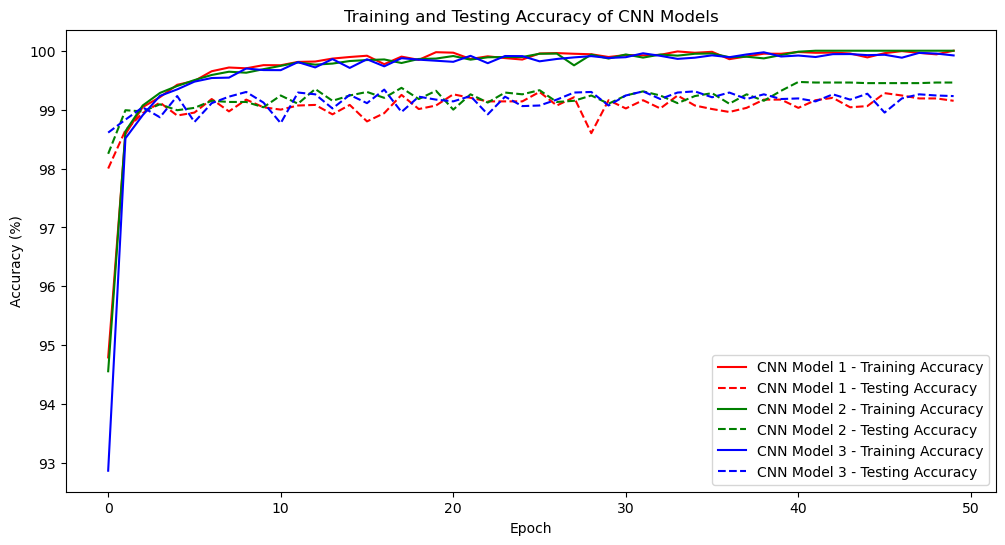

In [58]:
plt.figure(figsize=(12, 6))

# Plot Training Accuracy for each model
plt.plot(acc_cnn1, 'r-', label='CNN Model 1 - Training Accuracy')
plt.plot(test_acc_cnn1, 'r--', label='CNN Model 1 - Testing Accuracy')

plt.plot(acc_cnn2, 'g-', label='CNN Model 2 - Training Accuracy')
plt.plot(test_acc_cnn2, 'g--', label='CNN Model 2 - Testing Accuracy')

plt.plot(acc_cnn3, 'b-', label='CNN Model 3 - Training Accuracy')
plt.plot(test_acc_cnn3, 'b--', label='CNN Model 3 - Testing Accuracy')

# Title and labels
plt.title('Training and Testing Accuracy of CNN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [59]:
print("Results Summary:")
print("CNN Model 1 achieved a final accuracy of {:.2f}%.".format(acc_cnn1[-1]))
print("CNN Model 2 achieved a final accuracy of {:.2f}%.".format(acc_cnn2[-1]))
print("CNN Model 3 achieved a final accuracy of {:.2f}%.".format(acc_cnn3[-1]))

Results Summary:
CNN Model 1 achieved a final accuracy of 100.00%.
CNN Model 2 achieved a final accuracy of 100.00%.
CNN Model 3 achieved a final accuracy of 99.92%.
